# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">Porto Seguro’s Safe Driver Prediction - Kaggle</p>

## Predict if a driver will file an insurance claim next year

<img src='./img/safe-driving-730x432.jpeg' style='height:400px; border-radius: 5px;'/>

---
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">Contents:</p>

* [1. Introduction](#1)
    * [1.1 Data Description](#1.1)
    * [1.2 Libraries](#1.2)
    * [1.3 Loading Dataset](#1.3)
* [2. Preprocessing & Feature Engineering](#2)
    * [2.1 Target variable distribution](#2.1)
    * [2.2 Missing values](#2.2)
    * [2.3 Exploratory Analysis](#2.3)
    * [2.4 Features Importance](#2.4)
    * [2.5 Data transformation and normalization](#2.5)
* [3. Models](#3)
    * [3.1 LightGBM](#3.1)
    * [3.2 XGBoost](#3.2)
    * [3.3 Random Search for Hyper-Parameter Optimization](#3.3)
    * [3.4 LightGBM Tuned](#3.4)
* [4. Evaluation](#4)
    * [4.1 Normalized Gini Coefficient](#4.1)
    * [4.2 LightGBM](#4.2)
    * [4.3 XGBoost](#4.3)
    * [4.4 LightGBM Tuned](#4.4)
    * [4.5 ROC AUC](#4.5)
* [5. Kaggle Submission](#5)


<a id="1"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">1- Introduction</p>

<img title="Porto Seguro" src="img/porto-seguro-logo-1-3.png" alt="Porto Seguro" style='height:80px; padding: 10px; padding-right: 15px;' align="center"> 

[Porto Seguro](https://www.portoseguro.com.br/en/institutional) is one of the largest insurance companies in Brazil specialized in car and home insurance. Located in São Paulo, Porto Seguro has been one of the leading insurers in Brazil since its foundation in 1945.

A key challenge faced by all major insurers is, when it comes to car insurance, how to address fairness towards good drivers and try not to penalize those who have a good driving history on account of a few bad drivers. Inaccuracies in car insurance claim predictions usually raise its cost for good drivers and reduce the price for bad ones.

Porto Seguro has been applying Machine Learning for more than 20 years and intends to make car insurance more accessible to everyone.

<img title="Porto Seguro" src="img/Kaggle_logo.png" alt="Porto Seguro" style='height:80px; padding: 10px; padding-right: 15px' align="center">

[Kaggle](https://www.kaggle.com/) is an online community of data scientists and allows users to find and publish data sets, explore and build ML models, and enter competitions to solve data science challenges.

In this [competition](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/), the challenge is to build a model that predicts the probability that a car insurance policyholder will file a claim next year.

<a id="1.1"></a>
## Data Description

In the train and test data:

- Features that belong to similar groupings are tagged as such in the feature names (e.g., `ind`, `reg`, `car`, `calc`). 
- Feature names include the postfix `bin` to indicate binary features and `cat` to indicate categorical features.
- Features __without__ these designations are either __continuous or ordinal__.
- Values of `-1` indicate that the feature was missing from the observation. 
- The `target` columns signifies whether or not a claim was filed for that policy holder. 

<a id="1.2"></a>
## Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import random
import json
from pathlib import Path

%matplotlib inline
matplotlib.style.use("ggplot")

# Preprocessing
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# Models
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import joblib
from numpy import savetxt
from numpy import loadtxt

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from numpy import argmax

# Hyperparameter optimization
from sklearn.model_selection import RandomizedSearchCV

import time
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [3]:
from platform import python_version
print('Python version:', python_version())

Python version: 3.8.5


In [4]:
# !pip install -q -U watermark
%reload_ext watermark
%watermark -a "Leandro Pessini" --iversions

Author: Leandro Pessini

seaborn   : 0.11.1
joblib    : 1.0.1
sklearn   : 0.23.2
numpy     : 1.19.2
json      : 2.0.9
xgboost   : 1.4.1
matplotlib: 3.3.2
lightgbm  : 3.1.1
pandas    : 1.1.3



<a id="1.3"></a>
## Loading Dataset

In [5]:
# Kaggle
#path = "../input/porto-seguro-safe-driver-prediction/"

# Local
path = "./data/"

In [6]:
%%time
train_df = pd.read_csv(path + "train.csv").set_index('id')
test_df = pd.read_csv(path + "test.csv").set_index('id')

CPU times: user 9.78 s, sys: 2.27 s, total: 12.1 s
Wall time: 14.3 s


---
As per competition description, there are a few calculated features. In one of the discussions on Kaggle, it was highlighted that some kind of transformation was applied in order to generate these features. I will drop them and apply the transformations using my best judgment.

In [7]:
train_df = train_df.drop(train_df.filter(regex='_calc').columns, axis=1)
test_df = test_df.drop(test_df.filter(regex='_calc').columns, axis=1)

In [8]:
print('Train Dataset - Number of rows are',train_df.shape[0], 'and number of columns are ',train_df.shape[1])
print('Test Dataset - Number of rows are',test_df.shape[0], 'and number of columns are ',test_df.shape[1])

Train Dataset - Number of rows are 595212 and number of columns are  38
Test Dataset - Number of rows are 892816 and number of columns are  37


<a id="2"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">2- Preprocessing & Feature Engineering</p>

<a id="2.1"></a>
## Target variable distribution

`target` variable 1 means that a claim was filed and 0 that it was not claimed.

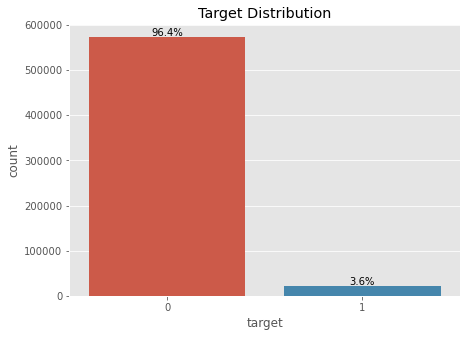

In [9]:
y = train_df.target
fig = plt.figure(figsize=(7, 5))
ax = sns.countplot(y,label="Count")

total_size = len(train_df)

# Display the target value ratio at the top of the bar
for patch in ax.patches:
    height = patch.get_height()
    width = patch.get_width()
    left_coord = patch.get_x()
    percent = height/total_size*100

    ax.text(x=left_coord + width/2.0, 
            y=height + 3000,
            s='{:1.1f}%'.format(percent),
            ha='center')

ax.set_title('Target Distribution');
plt.savefig('./plots/target_distribution.png', dpi=fig.dpi)

---
The target feature has a severe __imbalance distribution__ showing that only __3.6% filled a claim__ and 96.4% did not.

This will be handle by the algorithm on a hyperparameter `is_unbalance = True`.

<a id="2.2"></a>
## Missing values

Values of __`-1`__ indicate that the feature was missing from the observation.

In [10]:
vars_with_missing = []

for f in train_df.columns:
    missings = train_df[train_df[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/train_df.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('\nIn total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values

In total, there are 13 variables with missing values


---
Only `ps_car_03_cat` and `ps_car_05_cat` have a large number (~ >= 50%) of missing values.
- ps_car_03_cat has 411231 records (69.09%)
- ps_car_05_cat has 266551 records (44.78%)

<a id="2.1"></a>
## Metadata

To make data management easier, a meta-info about the variables is added to the DataFrame. It will help handling those variables later on the analysis, data viz and modeling.

- __level__: categorical, numerical, binary
- __dtype__: int, float, str

We do not have information on which features are ordinal or not so a meta-info `numerical` will be added in order to apply __Normalization__ later.

In [11]:
data = []
for f in train_df.columns:
    
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f:
        level = 'categorical'
    elif train_df[f].dtype == float:
        level = 'numerical'
    elif train_df[f].dtype == int:
        level = 'numerical'
    
    # Defining the data type 
    dtype = train_df[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'level': level,
        'dtype': dtype
    }
    
    data.append(f_dict)

In [12]:
meta = pd.DataFrame(data, columns=['varname', 'level', 'dtype'])
meta.set_index('varname', inplace=True)

In [13]:
# Example to extract all categorical variables that are not dropped
meta[(meta.level == 'categorical')].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

### Number of variables per role and level 

In [14]:
pd.DataFrame({'count' : meta.groupby(['level'])['level'].size()}).reset_index()

,level,count
0,binary,12
1,categorical,14
2,numerical,12


<a id="2.3"></a>
## Exploratory Analysis

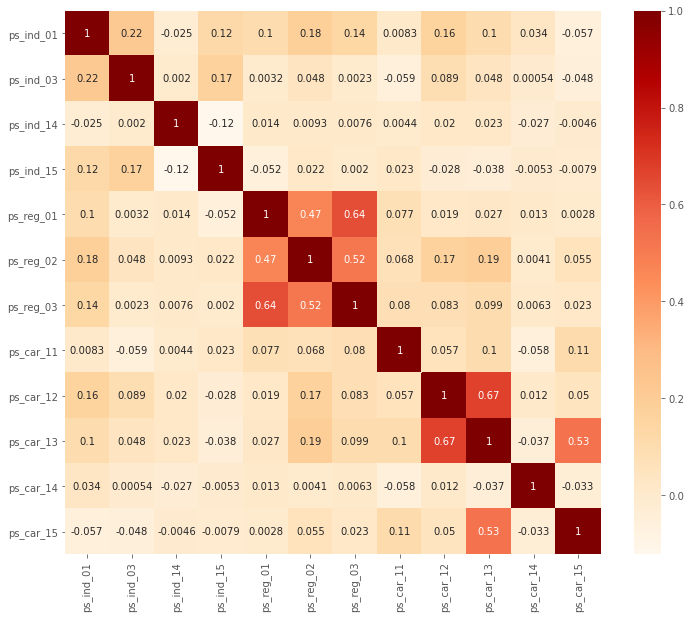

In [15]:
numerical_features = meta[(meta.level == 'numerical')].index
fig = plt.figure(figsize=(12, 10))
cont_corr = train_df[numerical_features].corr() # Correlation between continuous features
sns.heatmap(cont_corr, annot=True, cmap='OrRd'); # Plot heatmap
plt.savefig('./plots/heatmap.png', dpi=fig.dpi)

There are a strong correlations between the variables:

- ps_car_12 and ps_car_13 (0.67)
- ps_reg_01 and ps_reg_03 (0.64)
- ps_car_13 and ps_car_15 (0.53)
- ps_reg_02 and ps_reg_03 (0.52)

Heatmap showed low number of correlated variables, we'll look at three of highly correlated variables separately.

In [277]:
# Convert -1 from training data copy to np.NaN
train_copy = train_df.copy().replace(-1, np.NaN)
train_copy = train_copy.dropna()
s = train_copy.sample(frac=0.2)

__NOTE__: sampling was applied to speed up the process.

### ps_car_12 x ps_car_13

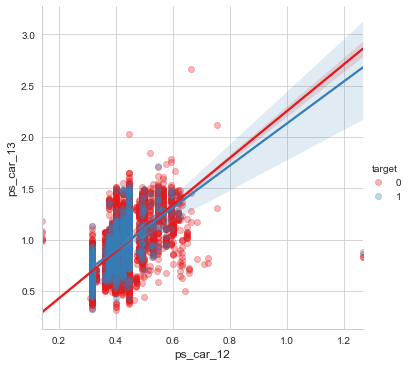

In [278]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.savefig('./plots/ps_car_12xps_car_13.png', dpi=fig.dpi)
plt.show()

### ps_reg_01 x ps_reg_03

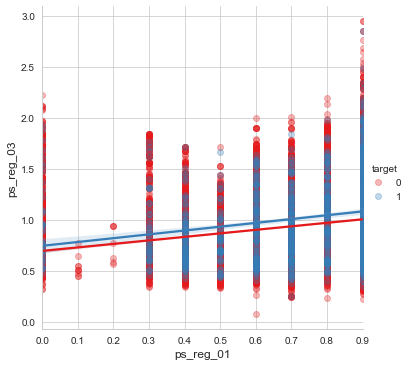

In [279]:
sns.lmplot(x='ps_reg_01', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.savefig('./plots/ps_reg_01xps_reg_03.png', dpi=fig.dpi)
plt.show()

### ps_reg_02 x ps_reg_03

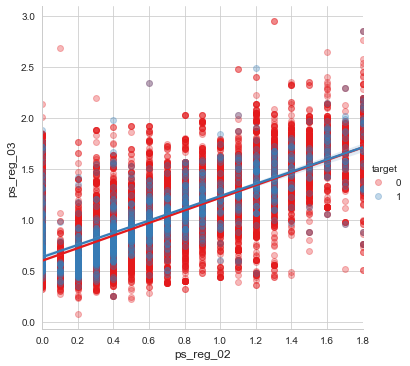

In [280]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.savefig('./plots/ps_reg_02xps_reg_03.png', dpi=fig.dpi)
plt.show()

As the number of correlated variables is rather low, dimensionality reduction will not be applied and the model will do the heavy-lifting.

## Binary features

__Distribution__ of binary data and the __corresponding__ values of __target__ variable.

<Figure size 432x288 with 0 Axes>

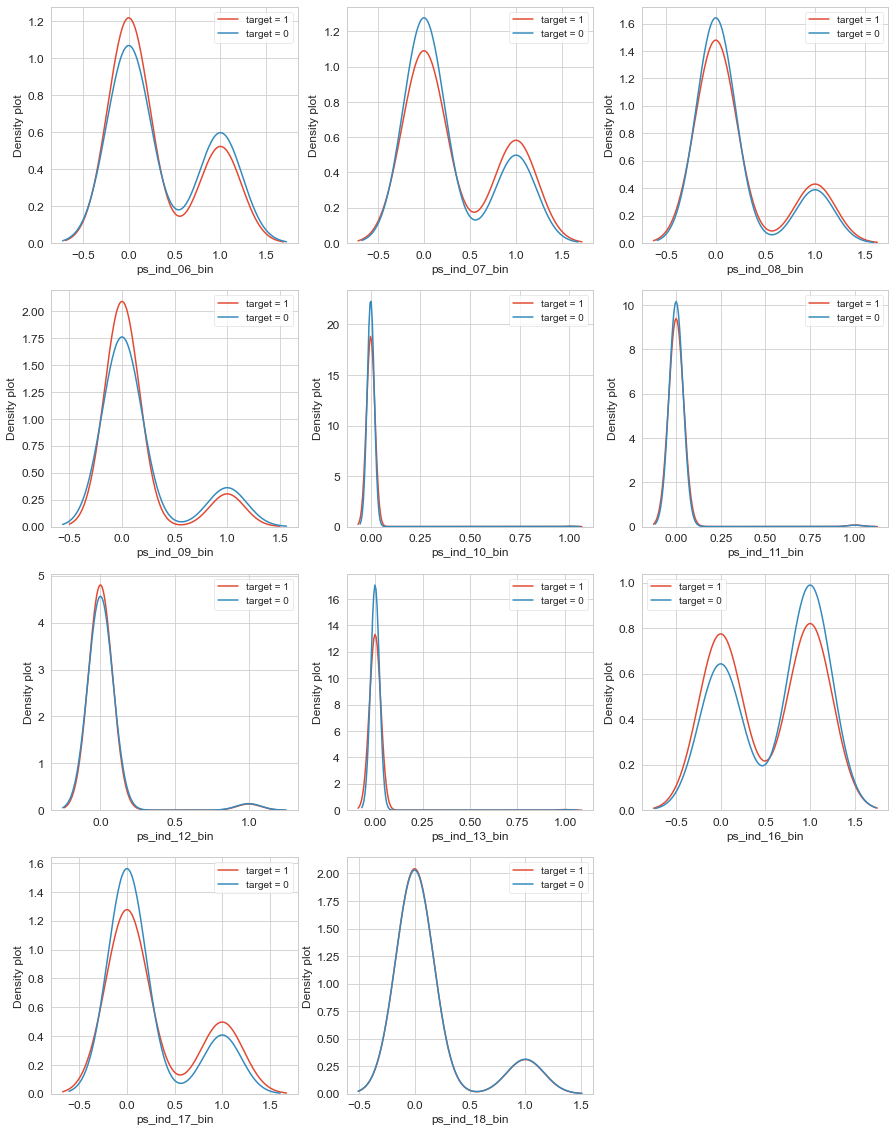

In [281]:
warnings.simplefilter(action='ignore')
var = [col for col in train_copy.columns if '_bin' in col]
i = 0

s_bin = train_copy.sample(frac=0.1)
t1 = s_bin.loc[s_bin['target'] != 0]
t0 = s_bin.loc[s_bin['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(figsize=(15,20))

for feature in var:
    i += 1
    plt.subplot(4,3,i)
    sns.kdeplot(t1[feature], bw=0.5, label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5, label="target = 0")
    plt.legend(loc='best')
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.savefig('./plots/binary-features.png', dpi=fig.dpi)
plt.show()

<a id="2.4"></a>
## Features Importance

As the categorical variables are already numerical, there is no need to apply LabelEncoding.

__Reference__:
>Raschka, S., & Mirjalili, V. (2019). Python Machine Learning. Zaltbommel, Netherlands: Van Haren Publishing.

In [ ]:
# Feature scaling
numerical_features = meta[(meta.level == 'numerical')].index
features_n = numerical_features.to_list()
training_normalized = train_df.copy()

features = training_normalized[features_n]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

training_normalized[features_n] = features

In [ ]:
training_data = training_normalized.copy()

In [ ]:
lgb_params_f = {
                'is_unbalance': True, # because training data is extremely unbalanced
                'objective': 'binary',
                'boosting_type': 'dart',
                'learning_rate': 0.01,
                'n_estimators': 500,
                'n_jobs': 2, # number of parallel threads
                'importance_type': 'gain'
                }
features_classifier = lgb.LGBMClassifier()
features_classifier.set_params(**lgb_params_f)

In [ ]:
y = training_data.target
X = training_data.drop(['target'], inplace=False, axis=1)

X, X_test, y, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)
predicts = []

for train_index, test_index in kf.split(X, y):
    print('-'*40)
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    features_classifier.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=250, early_stopping_rounds=50)
    #predicts.append(features_classifier.predict(X_test))
    
# saving the model
joblib_file = "./files/LightGBM_feature_importances.pkl"  
joblib.dump(features_classifier, joblib_file)

## Loading prefit model

In [21]:
try:
    with open("./files/LightGBM_feature_importances.pkl") as f:
        features_classifier = joblib.load(f.name)
        X = train_df.drop(['target'], inplace=False, axis=1)
except IOError:
    print("File not accessible")

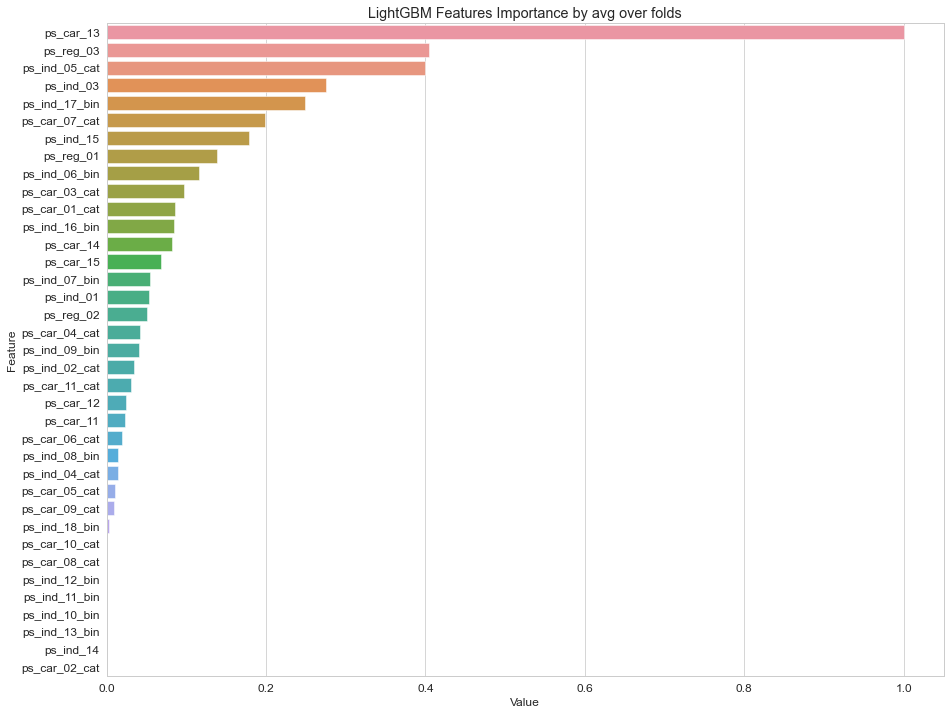

In [22]:
#Plotting features importance

feature_imp = pd.DataFrame(sorted(zip(features_classifier.feature_importances_,X.columns)), columns=['Value','Feature'])
scaler_ft = MinMaxScaler()
feature_imp['Value'] = scaler_ft.fit_transform(feature_imp['Value'].values.reshape(-1,1))

fig = plt.figure(figsize=(15, 12))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance by avg over folds')
plt.savefig('./plots/lgbm_importances.png', dpi=fig.dpi)
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

<a id="2.5"></a>
# Data transformation and normalization

### Combining train and test data
Now that we have the Feature Importance, let's join the train and test data in order to perform transformation on both.

In [23]:
all_data = pd.concat([train_df, test_df], ignore_index=True)
all_data = all_data.drop('target', axis=1) # Remove target value

## Dropping less important features

In [24]:
drop_features = ['ps_car_02_cat', 'ps_ind_14','ps_ind_10_bin', 
                 'ps_ind_11_bin','ps_ind_12_bin','ps_ind_13_bin', 
                 'ps_car_08_cat','ps_car_10_cat', 'ps_ind_18_bin', 'ps_car_09_cat', 'ps_car_05_cat']


all_data_remaining = all_data.drop(drop_features, axis=1)

print('Number of features before selection: {}'.format(all_data.shape[1]))
print('Number of features after selection: {}'.format(all_data_remaining.shape[1]))


Number of features before selection: 37
Number of features after selection: 26


In [25]:
all_data_feat_sel = all_data_remaining.copy()

## Handling missing data

The study of missing data was formalized by Donald Rubin with the concept of missing mechanism in which missing-data indicators are random variables and assigned a distribution. Missing data mechanism describes the underlying mechanism that generates missing data.

It is important to consider missing data mechanism when deciding how to deal with missing data. Because this is unknown, I will consider the missing data as part of the dataset (as a category) and just create a new feature adding the total number of missing data.

>Rubin, D. B. (1975). INFERENCE AND MISSING DATA. ETS Research Bulletin Series, 1975(1), i–19. https://doi.org/10.1002/j.2333-8504.1975.tb01053.x

In [26]:
feature_names = all_data_feat_sel.columns.tolist()
num_features = [c for c in feature_names if '_cat' not in c]
all_data_feat_sel['missing'] = (all_data_feat_sel==-1).sum(axis=1).astype(float)
num_features.append('missing')

<a id="2.2"></a>
## Feature scaling using StandardScaler

In [27]:
features_n = [col for col in all_data_feat_sel.columns if ('_cat' not in col and '_bin' not in col)]
all_data_n = all_data_feat_sel.copy()

features = all_data_n[features_n]

# using default 
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

all_data_n[features_n] = features

<a id="2.3"></a>
## One-hot encoding categorical features

In [28]:
all_data_enc = all_data_n.copy()
categoricals_features = [col for col in all_data_feat_sel.columns if '_cat' in col]

print('Before dummification we have {} variables in train'.format(all_data_enc.shape[1]))
all_data_enc = pd.get_dummies(all_data_enc, columns=categoricals_features, drop_first=True)
print('After dummification we have {} variables in train'.format(all_data_enc.shape[1]))

Before dummification we have 27 variables in train
After dummification we have 176 variables in train


## Split train and test data 

In [29]:
num_train = train_df.shape[0] # Number of train data 
final_data = all_data_enc.copy()

# Divide train data and test data
X = np.asarray(final_data[:num_train])
X_test = np.asarray(final_data[num_train:])

y = np.asarray(train_df['target'])

# Splitting the train to use 20% later on evaluation
X, X_eval, y, y_eval = train_test_split(X, y, test_size = 0.2)

<a id="3"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">3- Model</p>

## Normalized Gini - Kaggle Evaluation

In [30]:
def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

<a id="3.1"></a>
# LightGBM

In [54]:
lgb_params = {
        'objective': 'binary',
        'is_unbalance': True, # As we have a severe imbalanced class
        'metric': 'auc',
        'n_estimators': 500,
        'n_jobs': 2,
        'learning_rate': 0.01,
        'num_leaves': 30
    }
lgb_c = lgb.LGBMClassifier()
lgb_c.set_params(**lgb_params)

LGBMClassifier(is_unbalance=True, learning_rate=0.01, metric='auc',
               n_estimators=500, n_jobs=2, num_leaves=30, objective='binary')

__NOTE__
- __'is_unbalance': True__

Sets the weights of the dominated label to 1, and the weights of the dominant labels to the ratio of count of dominant/dominated.

## K-fold cross validation

K-fold cross-validation reports on the performance of a model on several (k) samples from your training set. This provides a less biased evaluation of the model. However, K-fold cross-validation is more computationally expensive than slicing your data into three parts. It re-fits the model and tests it k-times, for each iteration, as opposed to one time. 

It can be beneficial for many reasons, for example, when your data set is not large enough to slice into three representative parts, cross-validation can help with that. Preventing overfitting to your test data without further reducing the size of your training data set.

In [56]:
%%time

preds_proba_lgb = np.zeros([X.shape[0],2])
preds_lgb = np.zeros(X.shape[0])

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)

for n_fold, (train_index, test_index) in enumerate(folds.split(X, y)):
    print('#'*40, f'Fold {n_fold+1} out of {folds.n_splits}', '#'*40)
    
    X_train, y_train = X[train_index], y[train_index] # Train data
    X_val, y_val = X[test_index], y[test_index] # Valid data
    
    lgb_c.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
              verbose=250, early_stopping_rounds=50)
    
    preds_proba_lgb[test_index] += lgb_c.predict_proba(X_val, raw_score=False)
    preds_lgb[test_index] += lgb_c.predict(X_val, raw_score=False)

    # Normalized Gini coefficient for prediction probabilities
    gini_score = gini_normalized(y_val, preds_proba_lgb[test_index][:, 1])
    print(f'Fold {n_fold+1} gini score: {gini_score}\n')

######################################## Fold 1 out of 5 ########################################
Training until validation scores don't improve for 50 rounds
[250]	training's auc: 0.671216	valid_1's auc: 0.6393
[500]	training's auc: 0.688003	valid_1's auc: 0.641501
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.688003	valid_1's auc: 0.641501
Fold 1 gini score: 0.2830025558645673

######################################## Fold 2 out of 5 ########################################
Training until validation scores don't improve for 50 rounds
[250]	training's auc: 0.672502	valid_1's auc: 0.63852
Early stopping, best iteration is:
[308]	training's auc: 0.676627	valid_1's auc: 0.639076
Fold 2 gini score: 0.2781511995670359

######################################## Fold 3 out of 5 ########################################
Training until validation scores don't improve for 50 rounds
[250]	training's auc: 0.673034	valid_1's auc: 0.633694
Early stopping, best iteration is:


LightGBM total: __6min 43s__

## Saving the results

In [ ]:
# Save LightGBM model to file in the current working directory

joblib_file = "./files/lightgbm/LightGBM_Model.pkl"  
joblib.dump(lgb_c, joblib_file)

In [ ]:
with open('./files/lightgbm/evals_result.json', 'w') as fp:
    json.dump(lgb_c.evals_result_, fp, sort_keys=True, indent=4)

In [ ]:
np.savetxt('./files/lightgbm/preds_lgb.csv', preds_lgb, fmt = '%i')

In [ ]:
np.savetxt('./files/lightgbm/preds_prob_lgb.csv', preds_proba_lgb, fmt = '%s', delimiter=",")

<a id="3.2"></a>
# XGBoost (eXtreme Gradient Boosting)

In [32]:
params_xgb = {
    'objective': 'binary:logistic',
    'learning_rate': 0.01,
    'n_estimators': 500,
    #'missing': -1,
    'n_jobs': 2,
    'random_state': 1986
}
xgb_model = xgb.XGBClassifier(**params_xgb)

In [ ]:
%%time

preds_proba_xgb = np.zeros([X.shape[0],2])
preds_xgb = np.zeros(X.shape[0])

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)

for n_fold, (train_index, test_index) in enumerate(folds.split(X, y)):
    print('#'*40, f'Fold {n_fold+1} out of {folds.n_splits}', '#'*40)
    
    X_train, y_train = X[train_index], y[train_index] # Train data
    X_val, y_val = X[test_index], y[test_index] # Valid data
    
    xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
            eval_metric='auc', early_stopping_rounds=50, verbose = False)
    
    preds_proba_xgb[test_index] += xgb_model.predict_proba(X_val)
    preds_xgb[test_index] += xgb_model.predict(X_val)

    # Normalized Gini coefficient for prediction probabilities
    gini_score = gini_normalized(y_val, preds_proba_xgb[test_index][:, 1])
    print(f'Fold {n_fold+1} gini score: {gini_score}\n')


XGBoost total: __3h 34min 42s__

In [34]:
# Save XGBoost model to file in the current working directory

joblib_file = "./files/xgb/XGBoost_Model.pkl"  
joblib.dump(xgb_model, joblib_file)

['./files/xgb/XGBoost_Model.pkl']

In [36]:
with open('./files/xgb/evals_result.json', 'w') as fp:
    json.dump(xgb_model.evals_result_, fp, sort_keys=True, indent=4)

In [37]:
np.savetxt('./files/xgb/preds_xgb.csv', preds_xgb, fmt = '%i')

In [38]:
np.savetxt('./files/xgb/preds_prob_xgb.csv', preds_proba_xgb, fmt = '%s', delimiter=",")

<a id="3.3"></a>
# Random Search for Hyper-Parameter Optimization

Random Search for Hyper-Parameter Optimization

>https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

In [282]:
# Randomized Search CV
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

param_dist = {'learning_rate': [0.1, 0.01, 0.001],
              'max_bin': [500, 1000, 2000],
              'min_data_in_leaf': [500, 1000, 1500],
              'n_estimators': [500, 1500, 2000],
              'num_leaves': [10, 30, 50, 100],
              'bagging_freq': [1, 3, 5],
              'bagging_fraction': [0.25, 0.5, 0.75]
              }

n_iter_search = 10
randomsearh_lgb = lgb.LGBMClassifier()
random_search = RandomizedSearchCV(randomsearh_lgb, 
                                   param_distributions = param_dist, 
                                   n_iter = n_iter_search,
                                   return_train_score=True)
start = time()
random_search.fit(final_data[:num_train], train_df['target'])
print("RandomizedSearchCV: %.2f seconds for %d candidates to best parameters." 
      % ((time() - start), n_iter_search))

---

__NOTE__: Due to computing resources limitations I did not perform RandomizedSearchCV locally

__Parameters Tuning__ was performed on Kaggle and yield the output below:

---

![RandomizedSearchCV](./img/randomSearchCV.png)

`random_search.best_params_`

![Best-Params](./img/best-params.png)

<a id="3.4"></a>
# LightGBM Tuned

In [58]:
lgb_params_tuned = {
                'objective': 'binary',
                'is_unbalance': True, # As we have a severe imbalanced class
                'metric': 'auc',
                'n_estimators': 2500,
                'n_jobs': 2,
                'num_leaves': 50,
                'max_bin': 2000,
                'learning_rate': 0.001,
                'min_data_in_leaf': 200,
                'feature_fraction': 0.7,
                'bagging_freq': 1,
                'bagging_fraction': 0.5
            }

lgb_tuned = lgb.LGBMClassifier()
lgb_tuned.set_params(**lgb_params_tuned)

LGBMClassifier(bagging_fraction=0.5, bagging_freq=1, feature_fraction=0.7,
               is_unbalance=True, learning_rate=0.001, max_bin=2000,
               metric='auc', min_data_in_leaf=200, n_estimators=2500, n_jobs=2,
               num_leaves=50, objective='binary')

In [60]:
%%time

preds_proba_lgb_tuned = np.zeros([X.shape[0],2])
preds_lgb_tuned = np.zeros(X.shape[0])

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)

for n_fold, (train_index, test_index) in enumerate(folds.split(X, y)):
    print('#'*40, f'Fold {n_fold+1} out of {folds.n_splits}', '#'*40)
    
    X_train, y_train = X[train_index], y[train_index] # Train data
    X_val, y_val = X[test_index], y[test_index] # Valid data
    
    lgb_tuned.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
                  verbose=1250, early_stopping_rounds=200)
    
    preds_proba_lgb_tuned[test_index] += lgb_tuned.predict_proba(X_val)
    preds_lgb_tuned[test_index] += lgb_tuned.predict(X_val)

    # Normalized Gini coefficient for prediction probabilities
    gini_score = gini_normalized(y_val, preds_proba_lgb_tuned[test_index][:, 1])
    print(f'Fold {n_fold+1} gini score: {gini_score}\n')

######################################## Fold 1 out of 5 ########################################
Training until validation scores don't improve for 200 rounds
[1250]	training's auc: 0.679549	valid_1's auc: 0.640271
[2500]	training's auc: 0.690902	valid_1's auc: 0.642823
Did not meet early stopping. Best iteration is:
[2500]	training's auc: 0.690902	valid_1's auc: 0.642823
Fold 1 gini score: 0.2856459142142984

######################################## Fold 2 out of 5 ########################################
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
Training until

LightGBM Tuned total: __1h 6min 3s__

## Saving the results

In [61]:
# Save LightGBM model to file in the current working directory

joblib_file = "./files/lightgbm/LightGBM_tuned.pkl"  
joblib.dump(lgb_tuned, joblib_file)

['./files/lightgbm/LightGBM_tuned.pkl']

In [62]:
with open('./files/lightgbm/evals_result_tuned.json', 'w') as fp:
    json.dump(lgb_tuned.evals_result_, fp, sort_keys=True, indent=4)

In [63]:
np.savetxt('./files/lightgbm/preds_lgb_tuned.csv', preds_lgb_tuned, fmt = '%i')

In [64]:
np.savetxt('./files/lightgbm/preds_prob_lgb_tuned.csv', preds_proba_lgb_tuned, fmt = '%s', delimiter=",")

<a id="4"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">4- Evaluation</p>

<a id="4.1"></a>
# Normalized Gini Coefficient

The Gini index or Gini coefficient is a statistical measure of distribution that was developed by the Italian statistician Corrado Gini in 1912. It is used as a gauge of economic inequality, measuring income distribution among a population.

The Gini coefficient is equal to the area below the line of perfect equality (0.5 by definition) minus the area below the Lorenz curve, divided by the area below the line of perfect equality. In other words, it is double the area between the Lorenz curve and the line of perfect equality.

Gini is a vital metric for insurers because the main concern focuses on segregating high and low risks rather than predicting losses. The reason is that this information is used to price insurance risks and charging customers on their predicted loss is not accountable for expenses and profit.

Since this task is classification, AUC  was used as a metric because it's equivalent to using Gini since: 

$$ Gini = 2 * AUC - 1 $$

In order to compute gini coefficient we should apply two integrals with the cumulative proportion of positive class

$$A=\int_{0}^{1}F(x)dx\approx \sum_{i=1}^{n}F_{i}(x)\times \frac{1}{n}$$

$$B=\int_{0}^{1}x \; dx\approx \sum_{i=1}^{n}\frac{i}{n} \times \frac{1}{n}= \frac{1}{n^{2}}\times \frac{n\times (n+1)}{2}\approx 0.5$$

$$Gini\, coeff= A-B=\frac{1}{n}\left (\sum_{i=1}^{n}F_{i}(x) -\frac{n+1}{2}  \right)$$

__Reference__:
>https://theblog.github.io/post/gini-coefficient-intuitive-explanation/

Because both classes are important due to the segregating aspect mentioned on the Gini coefficient, the evaluation metric chosen will be AUC.

<a id="4.2"></a>
# LightGBM

In [71]:
lightgbm_model = joblib.load('./files/lightgbm/LightGBM_Model.pkl')
preds_lgb = np.fromstring(loadtxt('./files/lightgbm/preds_lgb.csv'))
preds_prob_lgb = np.loadtxt('./files/lightgbm/preds_prob_lgb.csv', delimiter=',')

In [112]:
lightgbm_eval_probs = lightgbm_model.predict_proba(X_eval)
lightgbm_eval_probs = lightgbm_eval_probs[:, 1]

In [144]:
roc_auc_lightgbm = roc_auc_score(y_eval, lightgbm_eval_probs)
print('LightGBM ROC AUC %.3f' % roc_auc_lightgbm)

LightGBM ROC AUC 0.666


In [127]:
# fpr = FalsePositiveRate
# tpr = TruePositiveRate

# calculate roc curves
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_eval, lightgbm_eval_probs)
# get the best threshold
J_lgbm = tpr_lgbm - fpr_lgbm # Youden's index
ix_lgbm = argmax(J_lgbm)
best_thresh_lgbm = thresholds_lgbm[ix_lgbm]
print('Best Threshold for LightGBM Model= %f' % (best_thresh_lgbm))

Best Threshold for LightGBM Model= 0.486313


- J = Sensitivity + Specificity – 1
- J = Sensitivity + (1 – FalsePositiveRate) – 1
- J = TruePositiveRate – FalsePositiveRate

>https://en.wikipedia.org/wiki/Youden%27s_J_statistic

In [168]:
lgbm_gini= gini(y_eval, lightgbm_eval_probs)
lgbm_gini_max = gini(y_eval, y_eval)
lgbm_ngini= gini_normalized(y_eval, lightgbm_eval_probs)
print('Gini: %.3f \nMax. Gini: %.3f \nNormalized Gini: %.3f' % (lgbm_gini, lgbm_gini_max, lgbm_ngini))

Gini: 0.160 
Max. Gini: 0.482 
Normalized Gini: 0.332


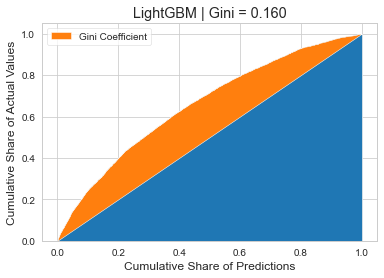

In [246]:
# Sort the actual values by the predictions
data_lgb = np.asarray(np.c_[y_eval, lightgbm_eval_probs,np.arange(len(y_eval))])
sorted_actual_lgb= data_lgb[np.lexsort((data_lgb[:,2],-1 * data_lgb[:, 1]))][:,0]

# Sum up the actual values
cumulative_actual_lgb = np.cumsum(sorted_actual_lgb)
cumulative_index_lgb = np.arange(1, len(cumulative_actual_lgb)+1)

cumulative_actual_shares_lgb = cumulative_actual_lgb / sum(y_eval)
cumulative_index_shares_lgb = cumulative_index_lgb / len(lightgbm_eval_probs)

# Add (0, 0) to the plot
x_values_lgb = [0] + list(cumulative_index_shares_lgb)
y_values_lgb = [0] + list(cumulative_actual_shares_lgb)

# Display the 45° line stacked on top of the y values
diagonal_lgb = [x - y for (x, y) in zip(x_values_lgb, y_values_lgb)]
plt.stackplot(x_values_lgb, y_values_lgb, diagonal_lgb, colors=['tab:blue', 'tab:orange'])
plt.legend(['_nolegend_','Gini Coefficient'], loc=2)
plt.xlabel('Cumulative Share of Predictions')
plt.ylabel('Cumulative Share of Actual Values')
plt.title('LightGBM | Gini = %.3f'%lgbm_gini)
plt.show()

<a id="4.3"></a>
# XGBoost

In [74]:
xgb_model = joblib.load('./files/xgb/XGBoost_Model.pkl')
preds_xgb = np.fromstring(loadtxt('./files/xgb/preds_xgb.csv'))
preds_prob_xgb = np.loadtxt('./files/xgb/preds_prob_xgb.csv', delimiter=',')

In [142]:
xgb_eval_probs = xgb_model.predict_proba(X_eval)
xgb_eval_probs = xgb_eval_probs[:, 1]

In [143]:
# calculate roc curves
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_eval, xgb_eval_probs)
# get the best threshold
J_xgb = tpr_xgb - fpr_xgb # Youden's index
ix_xgb = argmax(J_xgb)
best_thresh_xgb = thresholds_xgb[ix_xgb]
print('Best Threshold for XGBoost Model= %f' % (best_thresh_xgb))

Best Threshold for XGBoost Model= 0.040153


In [1]:
roc_auc_xgb = roc_auc_score(y_eval, xgb_eval_probs)
print('XGBoost ROC AUC %.3f' % roc_auc_xgb)

XGBoost ROC AUC 0.666


In [167]:
xgb_gini= gini(y_eval, xgb_eval_probs)
xgb_gini_max = gini(y_eval, y_eval)
xgb_ngini= gini_normalized(y_eval, xgb_eval_probs)
print('Gini: %.3f \nMax. Gini: %.3f \nNormalized Gini: %.3f' % (xgb_gini, xgb_gini_max, xgb_ngini))

Gini: 0.160 
Max. Gini: 0.482 
Normalized Gini: 0.332


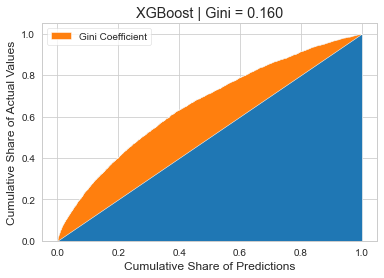

In [249]:
# Sort the actual values by the predictions
data_xgb = np.asarray(np.c_[y_eval, xgb_eval_probs,np.arange(len(y_eval))])
sorted_actual_xgb= data_lgb[np.lexsort((data_xgb[:,2],-1 * data_xgb[:, 1]))][:,0]

# Sum up the actual values
cumulative_actual_xgb = np.cumsum(sorted_actual_xgb)
cumulative_index_xgb = np.arange(1, len(cumulative_actual_xgb)+1)

cumulative_actual_shares_xgb = cumulative_actual_xgb / sum(y_eval)
cumulative_index_shares_xgb = cumulative_index_xgb / len(xgb_eval_probs)

# Add (0, 0) to the plot
x_values_xgb = [0] + list(cumulative_index_shares_xgb)
y_values_xgb = [0] + list(cumulative_actual_shares_xgb)

# Display the 45° line stacked on top of the y values
diagonal_xgb = [x - y for (x, y) in zip(x_values_xgb, y_values_xgb)]
plt.stackplot(x_values_xgb, y_values_xgb, diagonal_xgb, colors=['tab:blue', 'tab:orange'])
plt.legend(['_nolegend_','Gini Coefficient'], loc=2)
plt.xlabel('Cumulative Share of Predictions')
plt.ylabel('Cumulative Share of Actual Values')
plt.title('XGBoost | Gini = %.3f'%xgb_gini)
plt.show()

<a id="4.4"></a>
# LightGBM - Tuned Model

In [76]:
lightgbm_tuned = joblib.load('./files/lightgbm/LightGBM_tuned.pkl')
preds_lgb_tuned = np.fromstring(loadtxt('./files/lightgbm/preds_lgb_tuned.csv'))
preds_prob_lgb_tuned = np.loadtxt('./files/lightgbm/preds_prob_lgb_tuned.csv', delimiter=',')

In [146]:
lightgbm_tuned_eval_probs = lightgbm_tuned.predict_proba(X_eval)
lightgbm_tuned_eval_probs = lightgbm_tuned_eval_probs[:, 1]

In [147]:
roc_auc_lightgbm_tuned = roc_auc_score(y_eval, lightgbm_tuned_eval_probs)
print('LightGBM Tuned ROC AUC %.3f' % roc_auc_lightgbm_tuned)

LightGBM Tuned ROC AUC 0.676


In [148]:
# calculate roc curves
fpr_lgbm_tuned, tpr_lgbm_tuned, thresholds_lgbm_tuned = roc_curve(y_eval, lightgbm_tuned_eval_probs)
# get the best threshold
J_lgbm_tuned = tpr_lgbm_tuned - fpr_lgbm_tuned # Youden's index
ix_lgbm_tuned = argmax(J_lgbm_tuned)
best_thresh_lgbm_tuned = thresholds_lgbm_tuned[ix_lgbm_tuned]
print('Best Threshold for LightGBM Tuned Model= %f' % (best_thresh_lgbm_tuned))

Best Threshold for LightGBM Tuned Model= 0.457183


In [169]:
lgbm_tuned_gini= gini(y_eval, lightgbm_tuned_eval_probs)
lgbm_tuned_gini_max = gini(y_eval, y_eval)
lgbm_tuned_ngini= gini_normalized(y_eval, lightgbm_tuned_eval_probs)
print('Gini: %.3f \nMax. Gini: %.3f \nNormalized Gini: %.3f' % (lgbm_tuned_gini, 
                                                                lgbm_tuned_gini_max, 
                                                                lgbm_tuned_ngini))

Gini: 0.170 
Max. Gini: 0.482 
Normalized Gini: 0.352


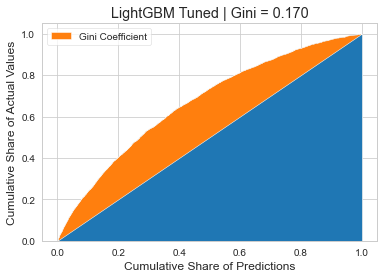

In [250]:
# Sort the actual values by the predictions
data_lgbm_tuned = np.asarray(np.c_[y_eval, lightgbm_tuned_eval_probs,np.arange(len(y_eval))])
sorted_actual_lgbm_tuned = data_lgbm_tuned[np.lexsort((data_lgbm_tuned[:,2],-1 * data_lgbm_tuned[:, 1]))][:,0]

# Sum up the actual values
cumulative_actual_lgbm_tuned = np.cumsum(sorted_actual_lgbm_tuned)
cumulative_index_lgbm_tuned = np.arange(1, len(cumulative_actual_lgbm_tuned)+1)

cumulative_actual_shares_lgbm_tuned = cumulative_actual_lgbm_tuned / sum(y_eval)
cumulative_index_shares_lgbm_tuned = cumulative_index_lgbm_tuned / len(lightgbm_tuned_eval_probs)

# Add (0, 0) to the plot
x_values_lgbm_tuned = [0] + list(cumulative_index_shares_lgbm_tuned)
y_values_lgbm_tuned = [0] + list(cumulative_actual_shares_lgbm_tuned)

# Display the 45° line stacked on top of the y values
diagonal_lgbm_tuned = [x - y for (x, y) in zip(x_values_lgbm_tuned, y_values_lgbm_tuned)]
plt.stackplot(x_values_lgbm_tuned, y_values_lgbm_tuned, diagonal_lgbm_tuned, colors=['tab:blue', 'tab:orange'])
plt.legend(['_nolegend_','Gini Coefficient'], loc=2)
plt.xlabel('Cumulative Share of Predictions')
plt.ylabel('Cumulative Share of Actual Values')
plt.title('LightGBM Tuned | Gini = %.3f'%lgbm_tuned_gini)
plt.show()

<a id="4.5"></a>
# ROC Area Under Curve (AUC) Score

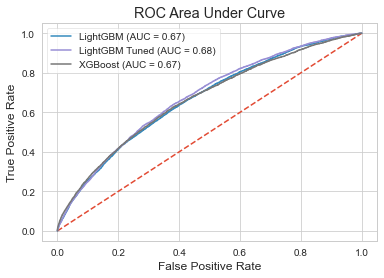

In [251]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr_lgbm, tpr_lgbm, label='LightGBM (AUC = %.2f)' % roc_auc_lightgbm)
plt.plot(fpr_lgbm_tuned, tpr_lgbm_tuned, label='LightGBM Tuned (AUC = %.2f)' % roc_auc_lightgbm_tuned)
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = %.2f)' % roc_auc_xgb)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Area Under Curve')
plt.legend()
# show the plot
plt.show()

All 3 models' performance (AUC) were very similar and using Random Search for Hyper-Parameter Optimization only increased 0.01 in AUC metric. One interesting point was about two models with the same score, LightGBM (first version) and XGBoost, but with almost 3,5 hours difference in training time.

## Comparative table

| Model              | Normalized Gini| AUC      | Training time   |
| :--------------    |:------------:  | :------: | -------------:  |
| LightGBM           | 0.33           | 0.67     | 6min 43s        |
| XGBoost            | 0.33           | 0.67     | 3h 34min 42s    |
| **LightGBM Tuned** | **0.35**       | **0.68** | **1h 6min 3s**  |

<a id="5"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">5- Kaggle Submission</p>

In [283]:
# X_test is the test.csv provided with all transformations applied
test_preds_lgb = lightgbm_tuned.predict_proba(X_test)
test_preds_xgb = xgb_model.predict_proba(X_test)

In [284]:
# slicing to get the probability for the positive class only
test_preds_lgb = test_preds_lgb[:,1:]
test_preds_xgb = test_preds_xgb[:,1:]

In [285]:
submission = pd.read_csv(path + 'sample_submission.csv', index_col='id')
submission['target'] = test_preds_lgb
submission.to_csv('./kaggle-submission/LightGBM.csv')

In [286]:
submission = pd.read_csv(path + 'sample_submission.csv', index_col='id')
submission['target'] = test_preds_xgb
submission.to_csv('./kaggle-submission/XGBoost.csv')

In [287]:
submission = pd.read_csv(path + 'sample_submission.csv', index_col='id')
ensemble_test_preds = test_preds_lgb * 0.6 + test_preds_xgb * 0.4
submission['target'] = ensemble_test_preds
submission.to_csv('./kaggle-submission/Ensemble.csv')